# YOLOv Balloon Detection Model
In this notebook a YOLOv8 model was trained over 250 epochs (144 after early stopping) on the V2 Balloon Detection Dataset 
( https://www.kaggle.com/datasets/vbookshelf/v2-balloon-detection-dataset ).The new model performas extremely well on balloons, showing high classification confidence and accuracy on real world images

In [1]:
import pandas as pd
import numpy as np
import os

import ast
import cv2

from sklearn.model_selection import train_test_split
import shutil
from tqdm.notebook import tqdm
import tqdm.notebook as tq

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Matplotlib is building the font cache; this may take a moment.


# Set up YOLOv8

In [2]:
import torch
from IPython.display import Image, clear_output

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.5.1 (CPU)


# Load V2 Balloon Detection Dataset

In [3]:
base_path = 'datasets/'

file = 'balloon-data.csv'

df_data = pd.read_csv(base_path + file)

# Convert bbox column entries from strings to lists
# "[........]" to [......]
df_data['bbox'] = df_data['bbox'].apply(ast.literal_eval)

print(df_data.shape)

df_data.head()

(74, 5)


fname  height  width  \
0  34020010494_e5cb88e1c4_k.jpg    1536   2048   
1  25899693952_7c8b8b9edc_k.jpg    1365   2048   
2  24362039530_b151b41a52_k.jpg    2048   1536   
3  18849792632_aad23ad513_k.jpg    2048   1536   
4  17178818589_16e58fc1e5_k.jpg    1536   2048   

                                                bbox  num_balloons  
0  [{'xmin': 994, 'ymin': 619, 'xmax': 1445, 'yma...             1  
1  [{'xmin': 135, 'ymin': 115, 'xmax': 811, 'ymax...             1  
2  [{'xmin': 579, 'ymin': 487, 'xmax': 920, 'ymax...             1  
3  [{'xmin': 534, 'ymin': 365, 'xmax': 871, 'ymax...            10  
4  [{'xmin': 748, 'ymin': 195, 'xmax': 1425, 'yma...             7

# Split dataset into training and testing

In [4]:
df_train, df_val = train_test_split(df_data, test_size=0.2, random_state=101)

print(df_train.shape)
print(df_val.shape)

(59, 5)
(15, 5)


# Install YOLOv8 Dependencies

In [102]:
!pip install -U ultralytics
!pip install clearml

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.5/485.5 kB 6.7 MB/s eta 0:00:0000:01
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.54
    Uninstalling ultralytics-8.0.54:
      Successfully uninstalled ultralytics-8.0.54
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [6]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=9E81M85KTA14Q3Q4ODCQ
%env CLEARML_API_SECRET_KEY=bDtmxKhV1FMEJPqvhiWrhp6jIvhGrupZsxhNFfjIXp05sByHq4

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=9E81M85KTA14Q3Q4ODCQ
env: CLEARML_API_SECRET_KEY=bDtmxKhV1FMEJPqvhiWrhp6jIvhGrupZsxhNFfjIXp05sByHq4


# Define the file structure below for YOLO

-> base_dir

    -> images
        -> train
        -> validation
        
    -> labels
        -> train
        -> validation

In [7]:
# Create a new directory inside the yolov8 directory
base_dir = base_path + 'base_dir'
os.mkdir(base_dir)

# Create directories inside the directory defined above for labels and images
# images
images = os.path.join(base_dir, 'images')
os.mkdir(images)
# labels
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)

# Create training and validation directories inside the above folders
# create new folders inside images
train = os.path.join(images, 'train')
os.mkdir(train)
validation = os.path.join(images, 'validation')
os.mkdir(validation)
# create new folders inside labels
train = os.path.join(labels, 'train')
os.mkdir(train)
validation = os.path.join(labels, 'validation')
os.mkdir(validation)

# Preprocess data
A separate text file must be created for each image with its bounding boxes. This function accomplishes this as well as moving the data into the file structure defined above.

In [8]:
# Iterate through each row in the dataframe

# We run the function below separately for
# the train and val sets.
# Remember that each image gets it's own text file
# containing the info for all bboxes on that image.

# For each image:
# 1- get the info for each bounding box
# 2- write the bounding box info to a txt file
# 3- save the txt file in the correct folder
# 4- copy the image to the correct folder


def process_data_for_yolo(df, data_type='train'):

    for _, row in tq.tqdm(df.iterrows(), total=len(df)):
        
        image_name = row['fname']
        bbox_list = row['bbox']
        
        image_width = row['width']
        image_height = row['height']
 
        
        # Convert into the Yolo input format
        # ...................................
        

        yolo_data = []
        
        # row by row
        for coord_dict in bbox_list:

            xmin = int(coord_dict['xmin'])
            ymin = int(coord_dict['ymin'])
            xmax = int(coord_dict['xmax'])
            ymax = int(coord_dict['ymax'])
            
            # We only have one class i.e. balloon.
            # We will set the class_id to 0 for all images.
            # Class numbers must start from 0.
            class_id = 0
            
            bbox_h = int(ymax - ymin)
            bbox_w = int(xmax - xmin)

            x_center = xmin + (bbox_w/2)
            y_center = ymin + (bbox_h/2)
            

            # Normalize
            # Yolo expects the dimensions to be normalized i.e.
            # all values between 0 and 1.

            x_center = x_center/image_width
            y_center = y_center/image_height
            bbox_w = bbox_w/image_width
            bbox_h = bbox_h/image_height

            # [class_id, x-center, y-center, width, height]
            yolo_list = [class_id, x_center, y_center, bbox_w, bbox_h]

            yolo_data.append(yolo_list)

        # convert to nump array
        yolo_data = np.array(yolo_data)


        # save the text file
        image_id = image_name.split('.')[0]
        np.savetxt('datasets/base_dir/' + f"labels/{data_type}/{image_id}.txt",
                    yolo_data, 
                    fmt=["%d", "%f", "%f", "%f", "%f"]
                    ) # fmt means format the columns

        # Copy the image to images
        shutil.copyfile(base_path + f"images/{image_name}",
            'datasets/base_dir/' + f"images/{data_type}/{image_name}")
        
        

# Call the function    
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

# Create yaml file

In [9]:
import yaml

yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 1,                             # number of classes
            'names': ['balloon']}                # list of label names

with open(r'balloon_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

# Train the model
The YOLOv8 model will be retrained based on its existing weights

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [103]:
!yolo task=detect mode=train model=yolov8n.pt imgsz=1028 data=balloon_data.yaml epochs=250 batch=4 name=yolov8n_balloon workers=8 momentum=0.7 weight_decay=0.0005

Ultralytics YOLOv8.0.55 🚀 Python-3.7.10 torch-1.13.1+cu117 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=balloon_data.yaml, epochs=250, patience=50, batch=4, imgsz=1028, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_balloon, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, 

# View Training Results

In [104]:
path2m = 'runs/detect/yolov8n_balloon38/'

In [105]:
model_df = pd.read_csv(path2m + 'results.csv')

display(model_df)

epoch           train/box_loss  \
0                          0                  0.61548   
1                          1                  0.61683   
2                          2                  0.60605   
3                          3                  0.62135   
4                          4                  0.66230   
..                       ...                      ...   
139                      139                  0.41886   
140                      140                  0.40687   
141                      141                  0.38466   
142                      142                  0.39328   
143                      143                  0.36202   

              train/cls_loss           train/dfl_loss  \
0                    3.14700                  1.05960   
1                    2.76310                  1.06470   
2                    2.12390                  1.00340   
3                    1.83770                  1.01140   
4                    1.57270                  1.02160   
..                       ...                      ...   
139                  0.61383                  0.89650   
140                  0.58893                  0.88025   
141                  0.54071                  0.88423   
142                  0.59850                  0.89885   
143                  0.57144                  0.87455   

        metrics/precision(B)        metrics/recall(B)  \
0                    0.01067                  0.82759   
1                    0.01156                  0.89655   
2                    1.00000                  0.21967   
3                    0.84550                  0.47188   
4                    0.80356                  0.56897   
..                       ...                      ...   
139                  0.95234                  0.68910   
140                  0.93022                  0.68950   
141                  0.85920                  0.73654   
142                  0.96726                  0.65517   
143                  0.99329                  0.65517   

            metrics/mAP50(B)      metrics/mAP50-95(B)  \
0                    0.39431                  0.29257   
1                    0.64439                  0.54075   
2                    0.53791                  0.44328   
3                    0.60977                  0.46375   
4                    0.70707                  0.57409   
..                       ...                      ...   
139                  0.77091                  0.64656   
140                  0.78516                  0.65997   
141                  0.78386                  0.64541   
142                  0.75205                  0.62227   
143                  0.72712                  0.58179   

                val/box_loss             val/cls_loss  \
0                    0.51355                   3.0857   
1                    0.54129                   2.8992   
2                    0.74959                   2.7324   
3                    0.87144                   2.3941   
4                    0.75993                   2.2557   
..                       ...                      ...   
139                  0.68836                   1.1919   
140                  0.65466                   1.1540   
141                  0.68635                   1.2152   
142                  0.71804                   1.2565   
143                  0.79682                   1.3065   

                val/dfl_loss                   lr/pg0  \
0                    0.96337                 0.087400   
1                    0.93694                 0.073889   
2                    1.10240                 0.060365   
3                    1.22120                 0.046830   
4                    1.06830                 0.033283   
..                       ...                      ...   
139                  1.20010                 0.004535   
140                  1.15790                 0.004496   
141                  1.19230                 0.004456   
142                  1.22510

Next we will view trends within the above dataframe.

In [106]:
img = mpimg.imread(path2m + 'results.png')

fig = plt.figure(figsize=(12,12), dpi=500)

plt.imshow(img, interpolation='none')
plt.axis('off')
plt.show()

# View P, R, PR, and F1 curves
As we can see from the curves, this YOLO model is able to detect balloons at extreme efficiencies.

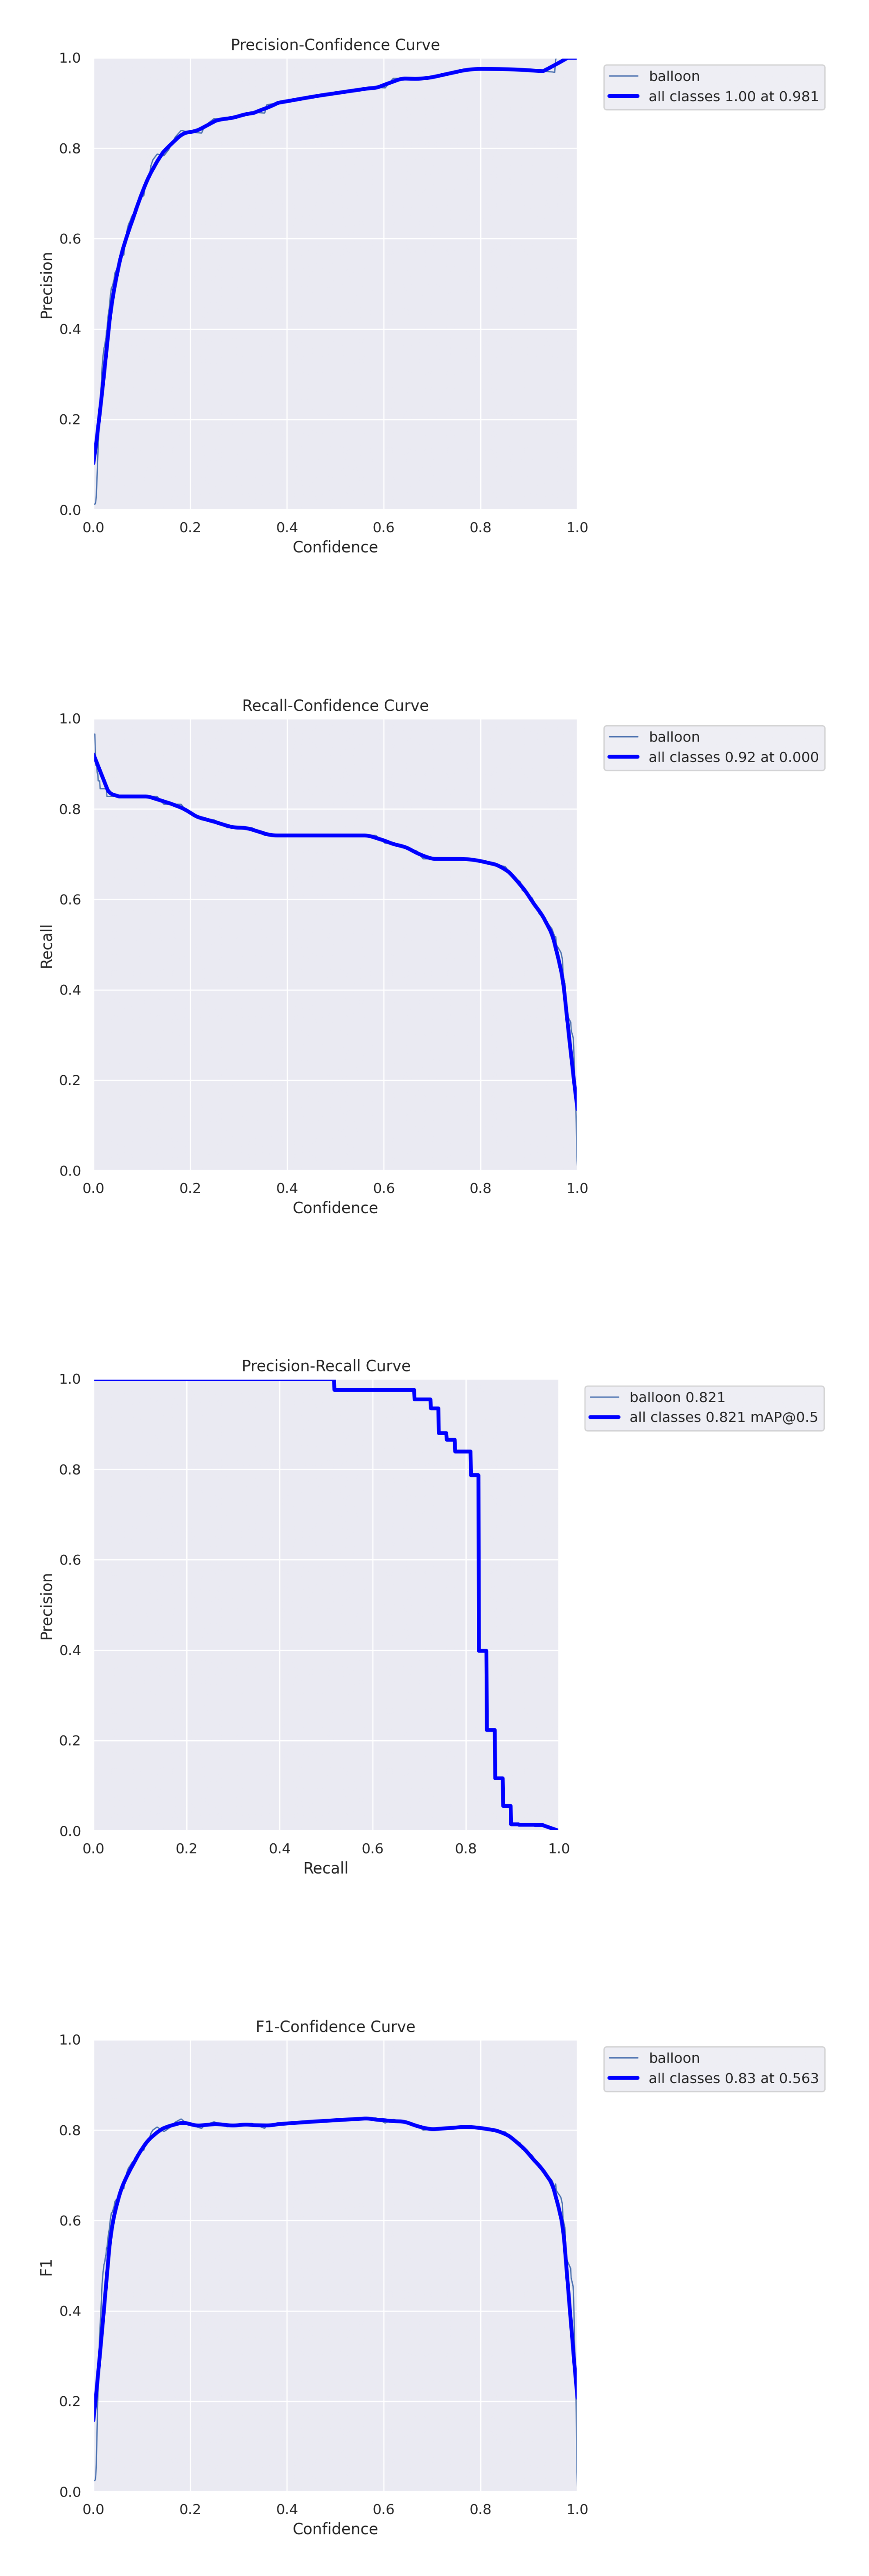

In [107]:
# Load the curve images
p_crv = mpimg.imread(path2m + 'P_curve.png')
r_crv = mpimg.imread(path2m + 'R_curve.png')
pr_crv = mpimg.imread(path2m + 'PR_curve.png')
f1_crv = mpimg.imread(path2m + 'F1_curve.png')

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(5, 15), dpi=500)

# Display the curves in the subplots
axs[0].imshow(p_crv)
axs[1].imshow(r_crv)
axs[2].imshow(pr_crv)
axs[3].imshow(f1_crv)

# Turn off the axis labels
for ax in axs.flatten():
    ax.axis('off')

# Show the plot
plt.show()

# View Confusion Matrix
We have a good model!

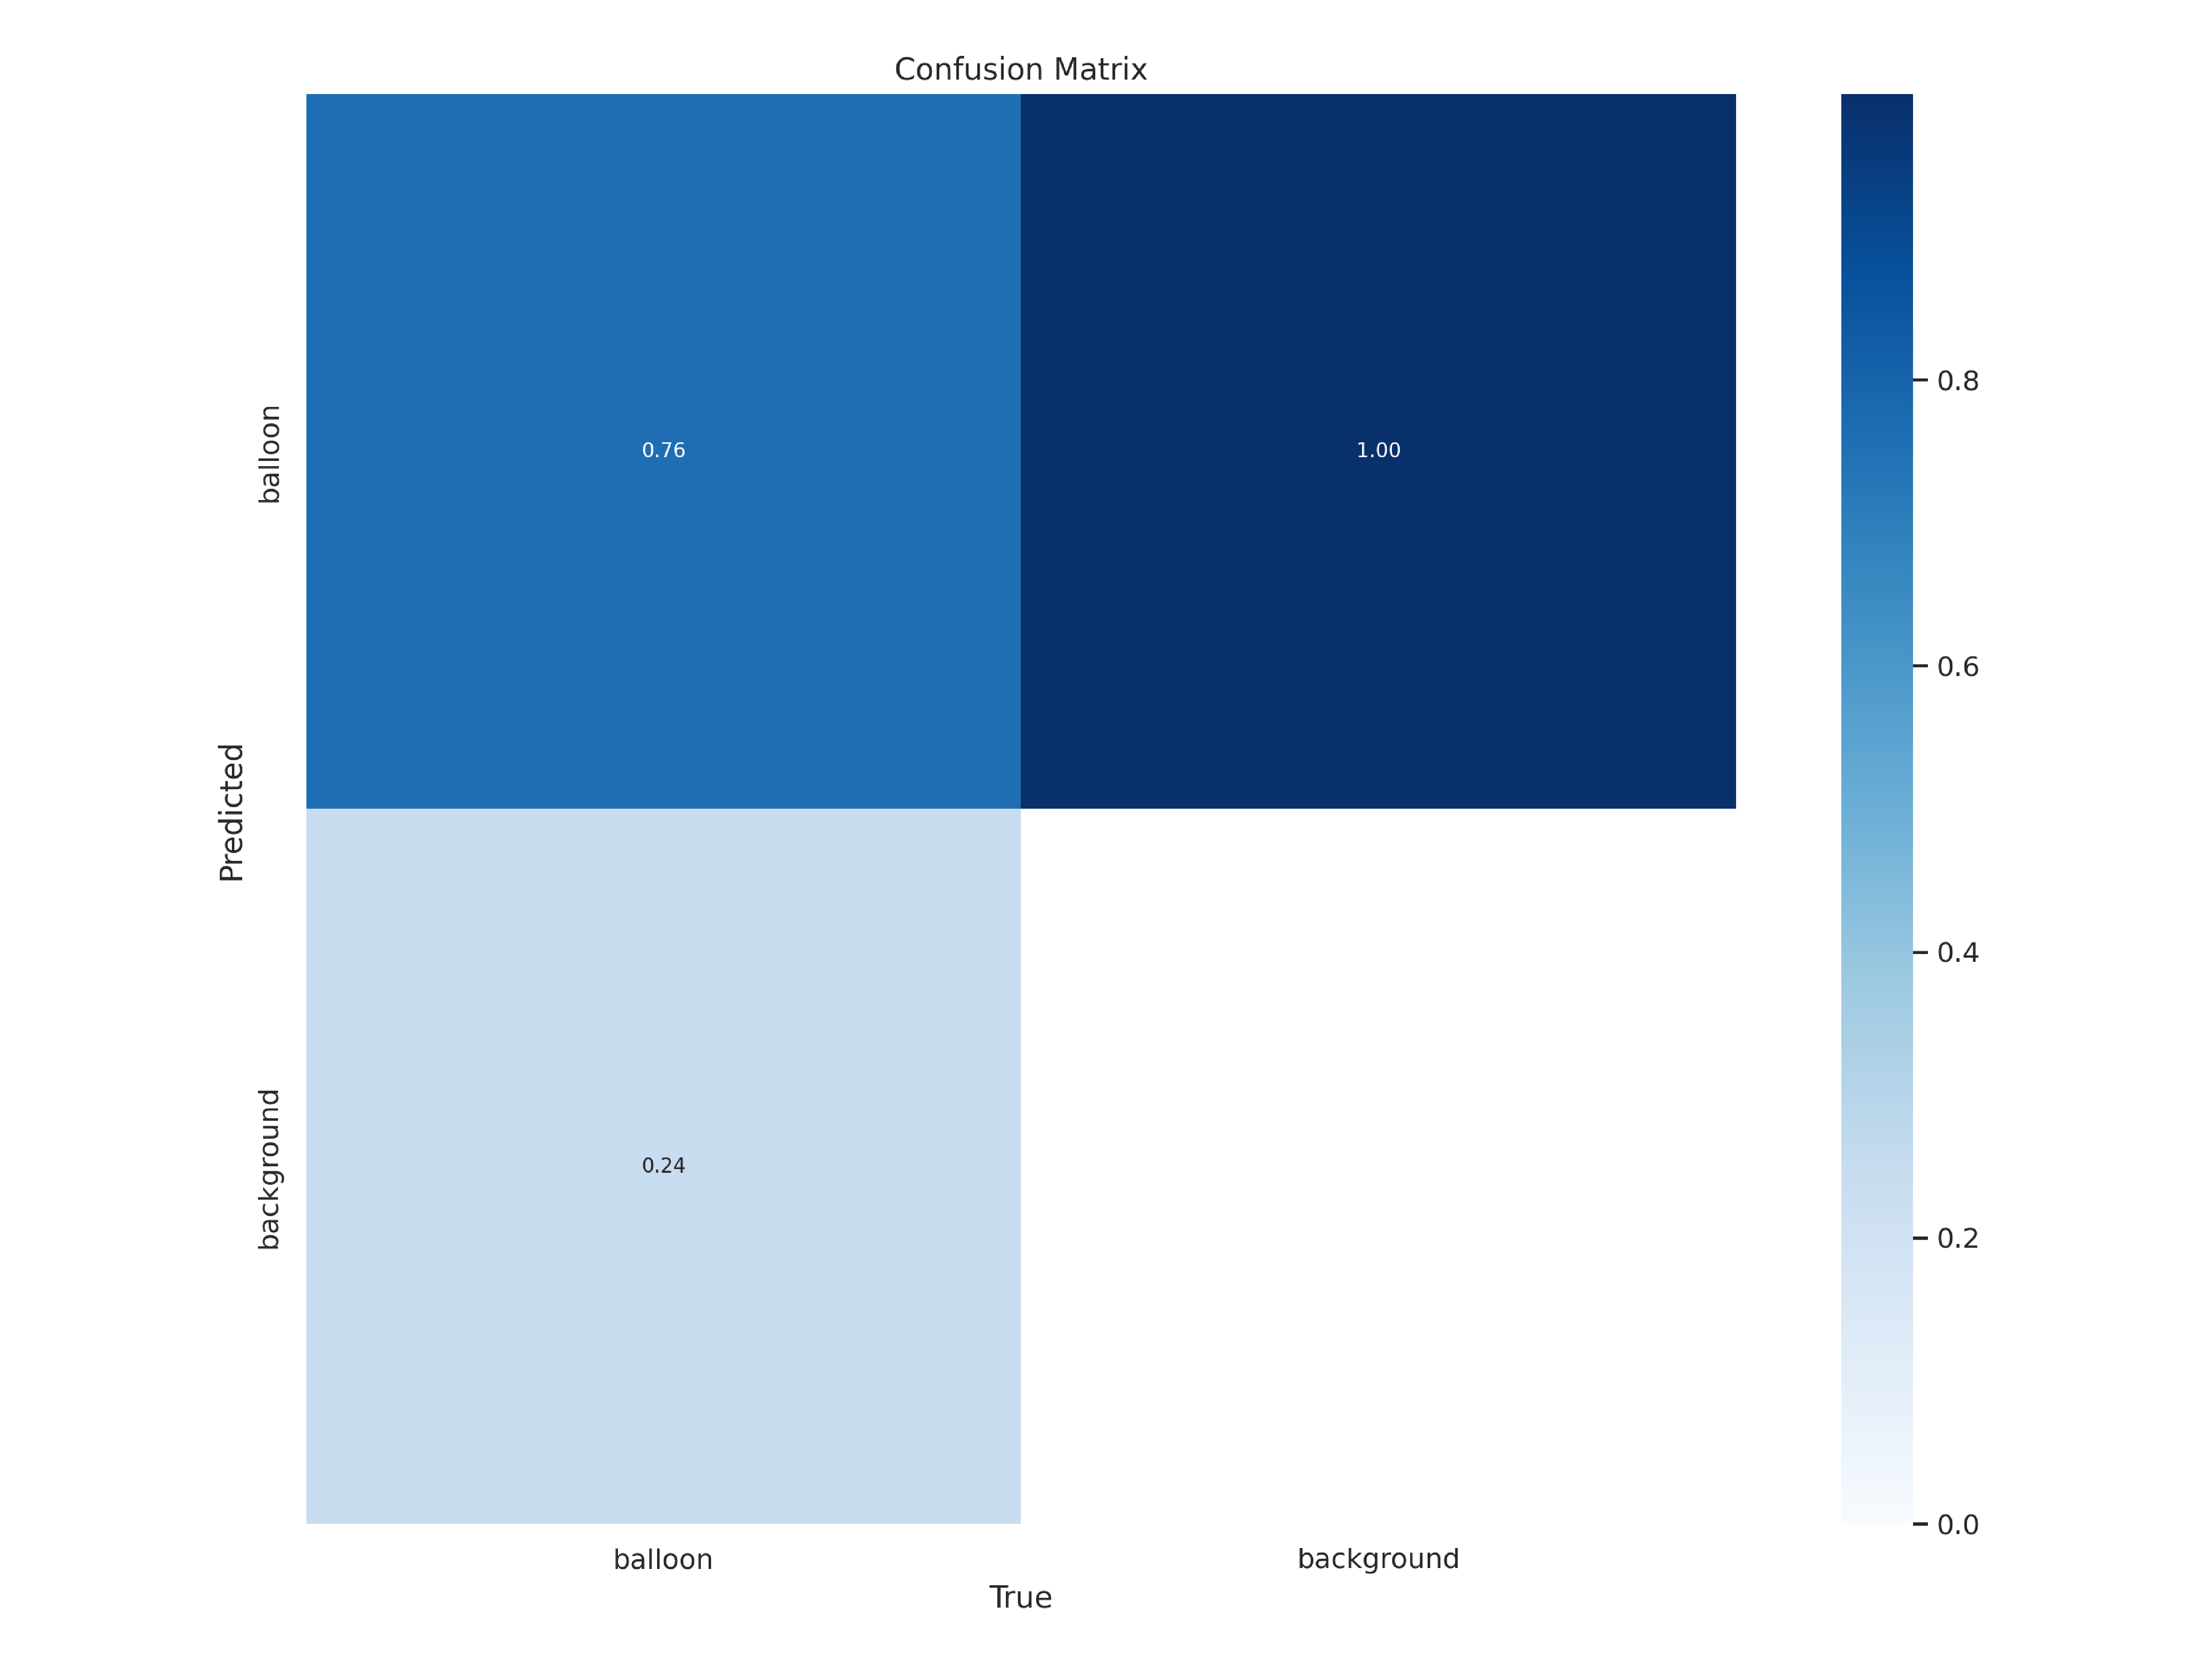

In [108]:
img = mpimg.imread(path2m + 'confusion_matrix.png')

fig = plt.figure(figsize=(12,12), dpi=500)

plt.imshow(img, interpolation='none')
plt.axis('off')
plt.show()

# Display Validation Images
YOLO made predictions on three sets of validation images. They're shown below along with their labeled counterparts

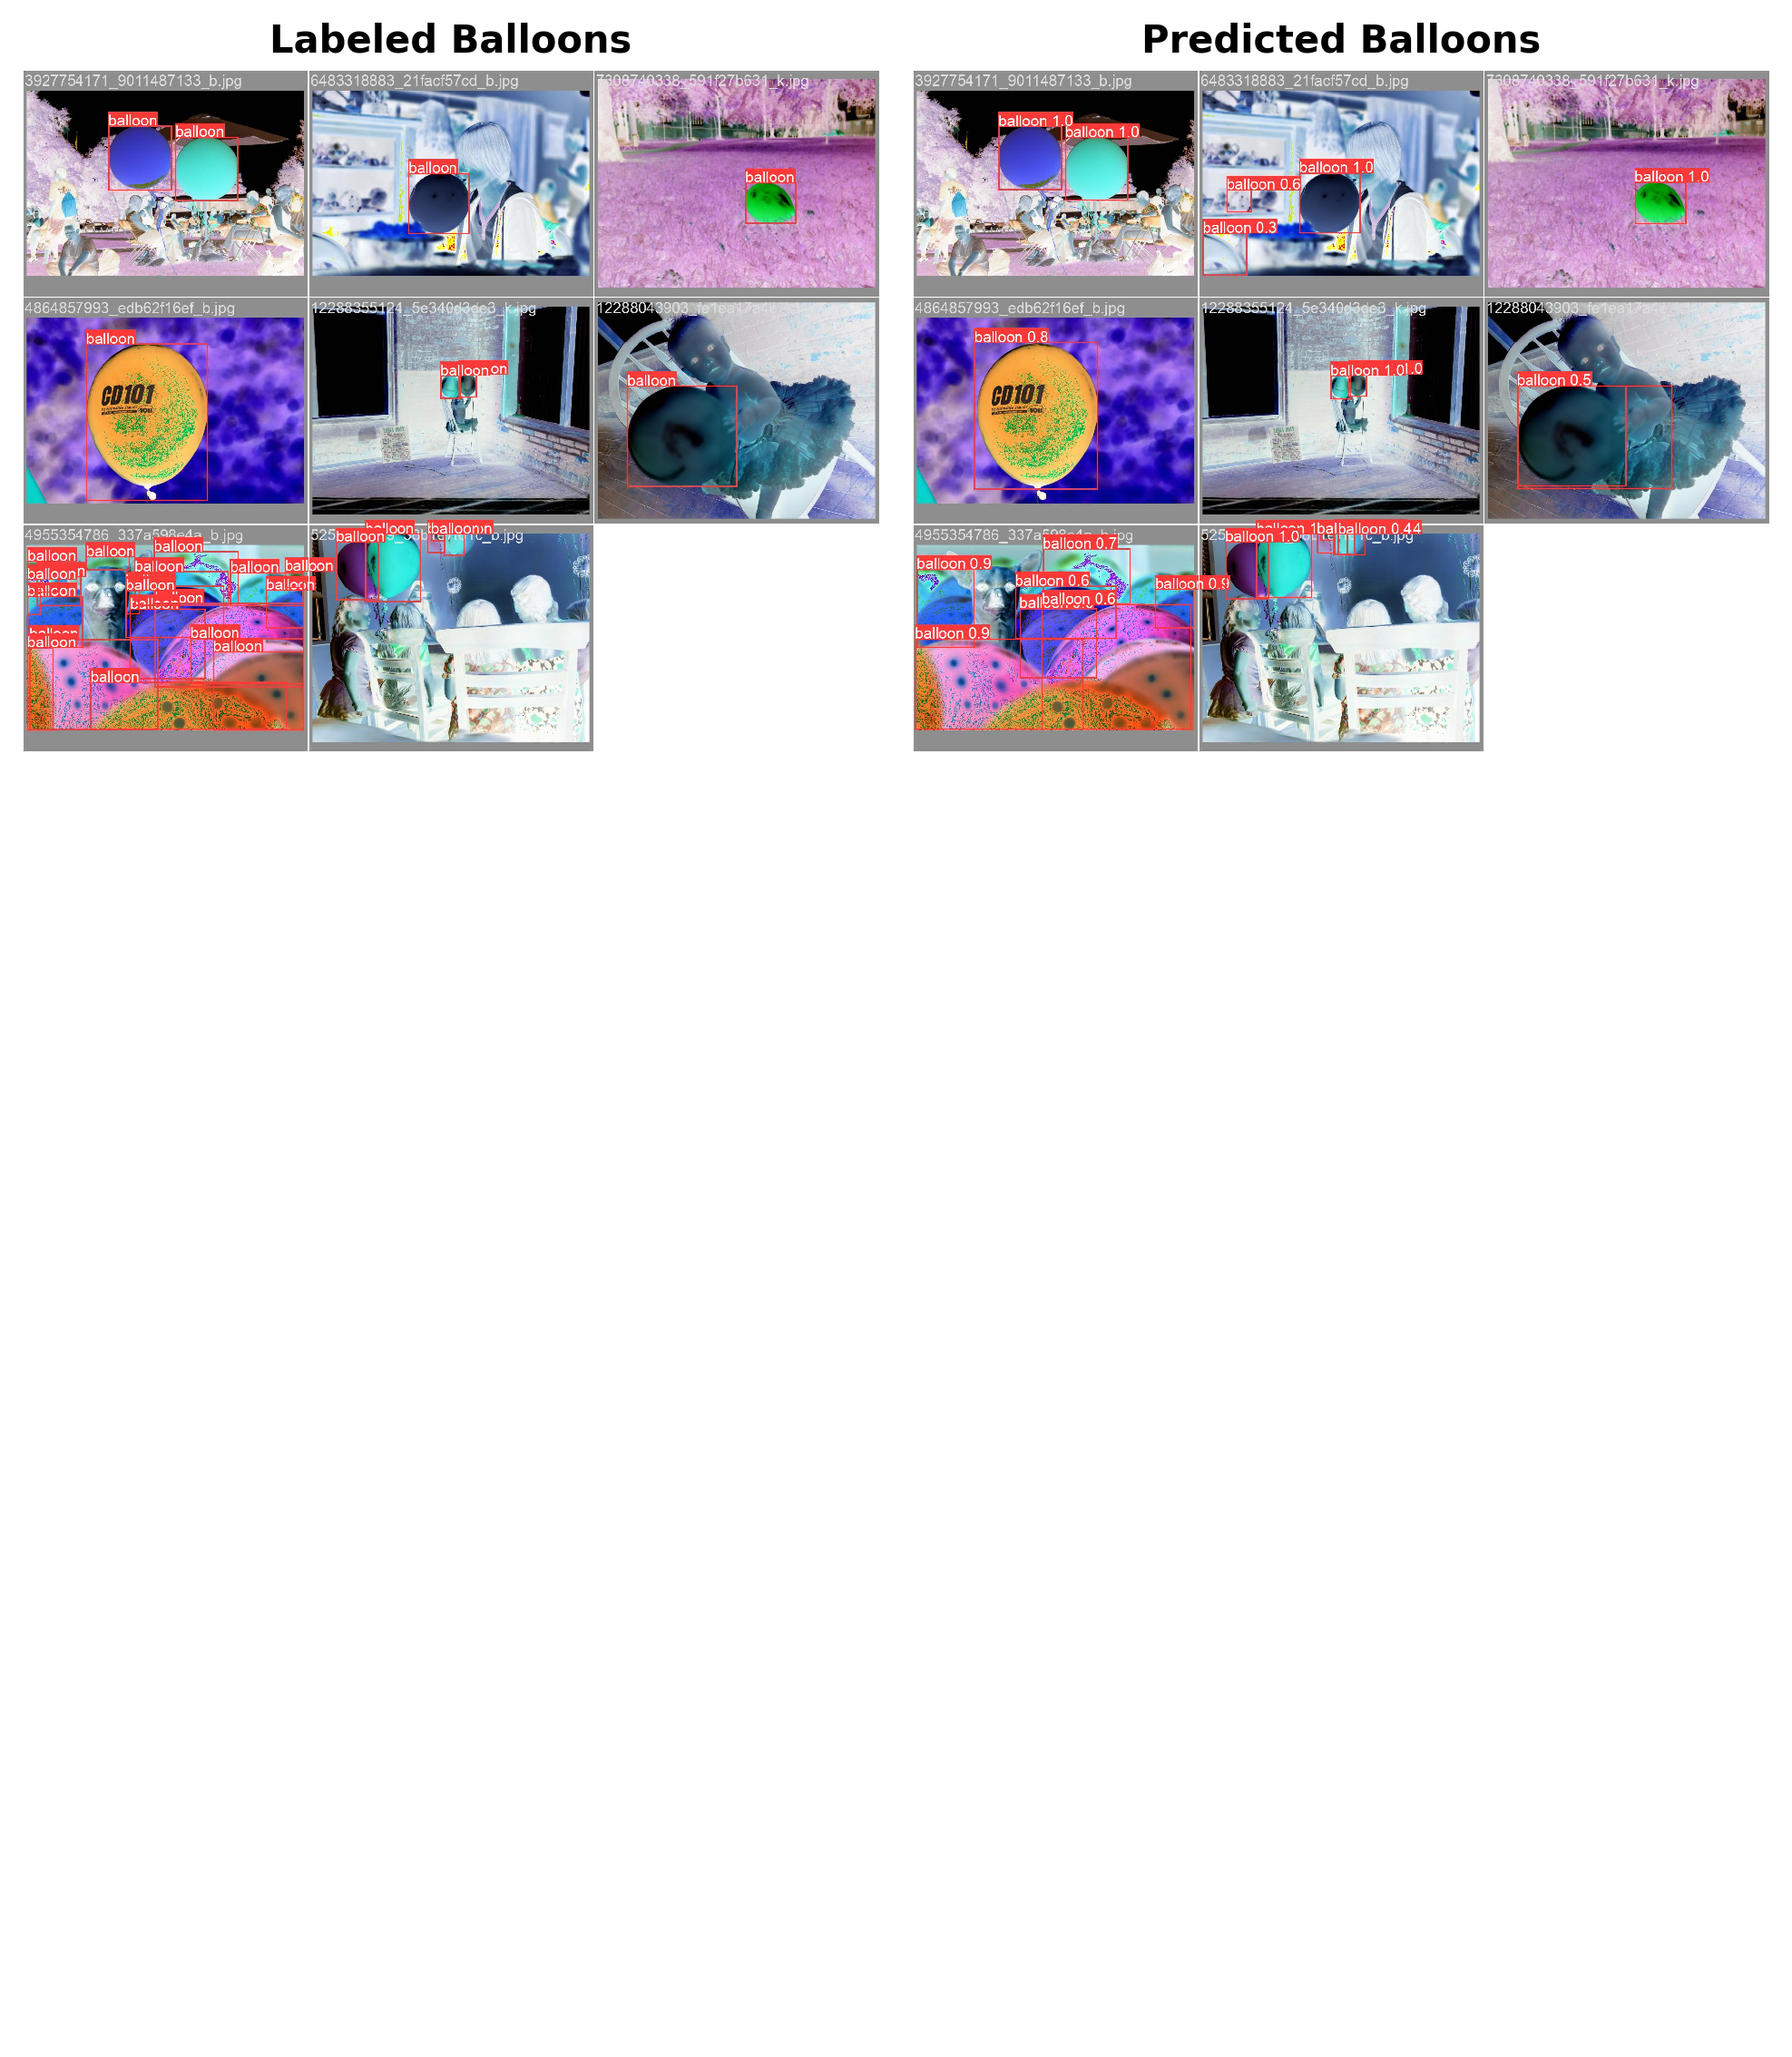

In [110]:
# Define the file locations of the images
img_files = [path2m + 'val_batch0_labels.jpg', path2m + 'val_batch0_pred.jpg']#,
#              path2m + 'val_batch1_labels.jpg', path2m + 'val_batch1_pred.jpg',
#              path2m + 'val_batch2_labels.jpg', path2m + 'val_batch2_pred.jpg',]

# Load the images into NumPy arrays
images = [mpimg.imread(f) for f in img_files]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 10), dpi=250)

# Set the left column to say "Labels" and the right column to say "Predicted"
axes[0, 0].set_title('Labeled Balloons', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Predicted Balloons', fontsize=12, fontweight='bold')


# Plot each image in a subplot
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], interpolation='none')
    ax.set_axis_off()

# Display the plot
plt.tight_layout()
plt.show()

# Test Custom YOLOv5 Model on Original Image
Enjoy this photo of me holding a balloon

In [122]:
!yolo task=detect mode=predict model=runs/detect/yolov8n_balloon38/weights/best.pt conf=0.5 source=test/ save=True save_txt=True

Ultralytics YOLOv8.0.55 🚀 Python-3.7.10 torch-1.13.1+cu117 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/2 /home/ec2-user/SageMaker/test/test_image.jpg: 1056x800 1 balloon, 172.1ms
image 2/2 /home/ec2-user/SageMaker/test/test_image2.jpg: 736x1056 (no detections), 145.2ms
Speed: 2.2ms preprocess, 158.6ms inference, 0.7ms postprocess per image at shape (1, 3, 1056, 1056)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


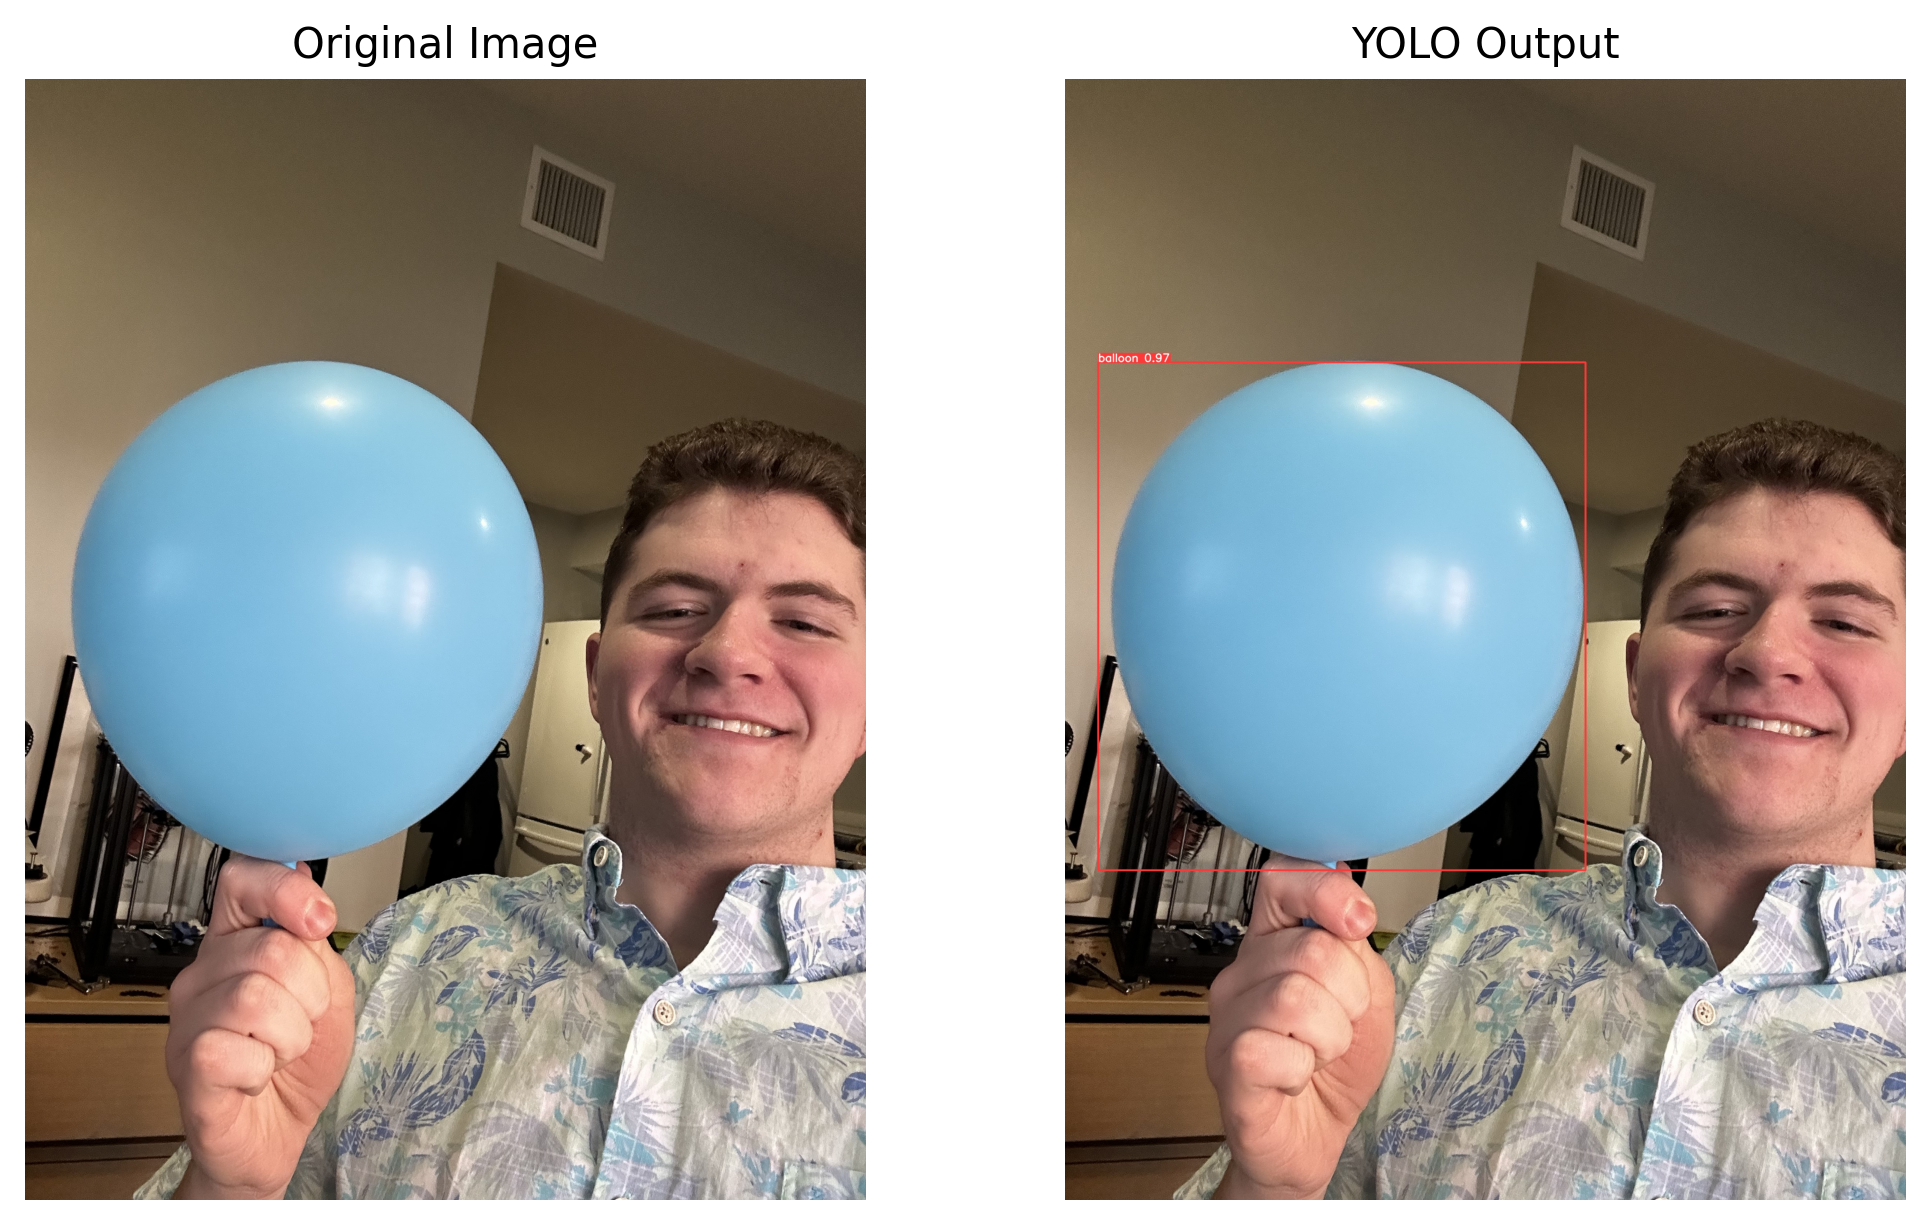

In [123]:
# Load the predicted image and the original image
original = cv2.imread('test/test_image.jpg')
predicted = cv2.imread('runs/detect/predict/test_image.jpg')

# Convert the images from BGR to RGB
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)

# Display the two images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=250)

ax1.imshow(original)
ax1.set_title('Original Image')
ax1.axis('off')
plt.tight_layout()


ax2.imshow(predicted)
ax2.set_title('YOLO Output')
ax2.axis('off')
plt.tight_layout()

plt.show()

# Print the location of the Bounding Box

In [124]:
# Load the YOLO output file
yolo_output_file = "runs/detect/predict/labels/test_image.txt"
yolo_output = np.loadtxt(yolo_output_file, dtype=float, delimiter=" ")

# Extract the bounding box coordinates from the YOLO output
class_id, x, y, w, h = yolo_output

# Define the dimensions of the original image
width, height = 1056, 1056

# Calculate the coordinates of the top-left and bottom-right corners of the bounding box
x1 = int((x - w/2) * width)
y1 = int((y - h/2) * height)
x2 = int((x + w/2) * width)
y2 = int((y + h/2) * height)

# Print the bounding box coordinates
print("Bounding box: ({}, {}), ({}, {})".format(x1, y1, x2, y2))

Bounding box: (41, 267), (653, 745)


# Test an image with no balloons
We shouldn't see any bounding boxes in the output file

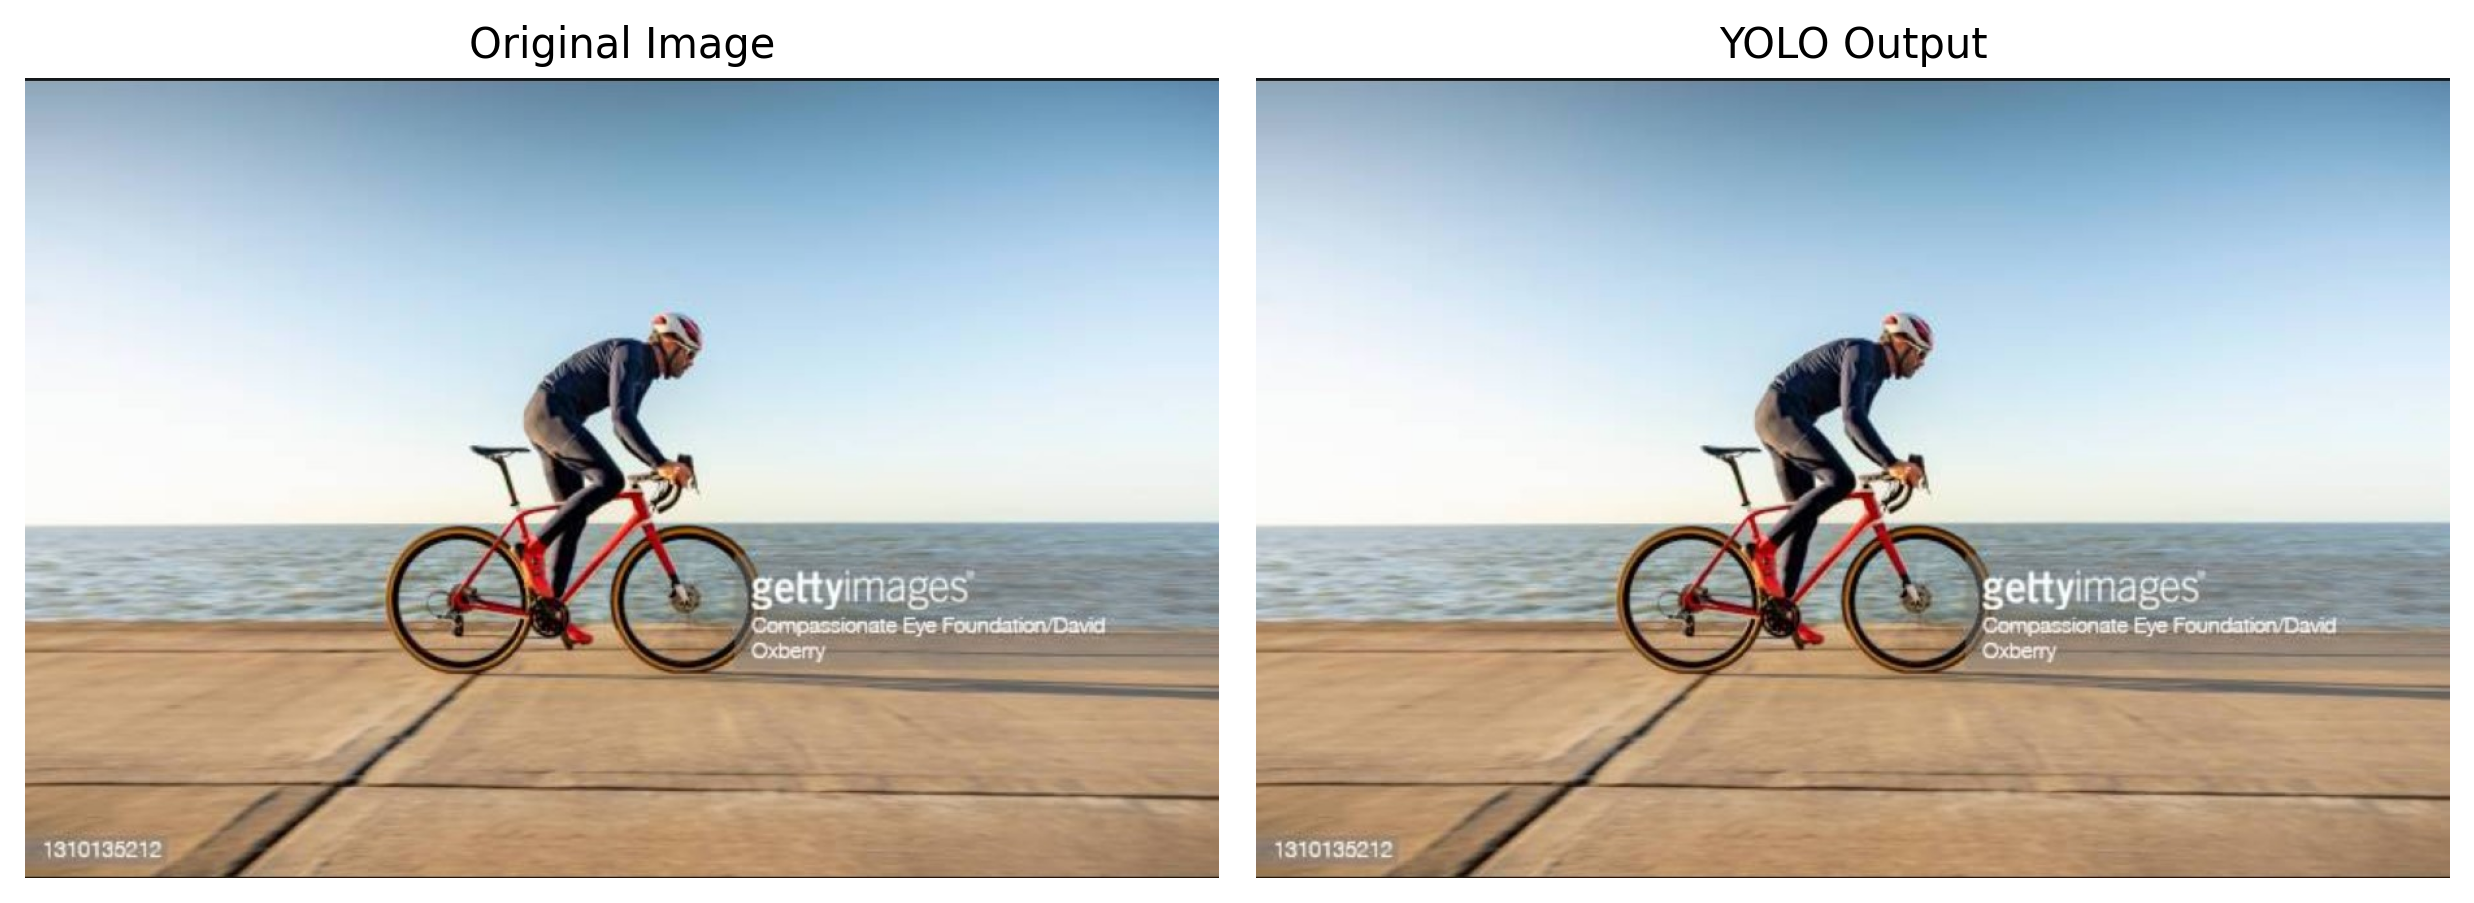

In [125]:
# Load the predicted image and the original image
original = cv2.imread('test/test_image2.jpg')
predicted = cv2.imread('runs/detect/predict/test_image2.jpg')

# Convert the images from BGR to RGB
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)

# Display the two images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=250)

ax1.imshow(original)
ax1.set_title('Original Image')
ax1.axis('off')
plt.tight_layout()


ax2.imshow(predicted)
ax2.set_title('YOLO Output')
ax2.axis('off')
plt.tight_layout()

plt.show()